In [1]:
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import (
    Conv2D,
    Input,
    LeakyReLU,
    ReLU,
    RepeatVector,
    Reshape,
    concatenate,
    UpSampling2D,
    BatchNormalization,
    MaxPooling2D,
)
from keras.models import Model, load_model


In [2]:
IMAGES_DIR = Path("images")
MODELS_DIR = Path("models")

WIDTH = 128
HEIGHT = 128
SIZE = (WIDTH, HEIGHT)
BATCH = 8

In [3]:
def preprocess_image(image_path):
    image = cv.imread(str(image_path), cv.IMREAD_COLOR)
    image = cv.resize(image, SIZE)
    image = image.astype(np.uint8)
    image = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    image = image.astype(np.float32)
    image /= 255.
    l, a, b = cv.split(image)
    ab = cv.merge([a, b])
    return (l, ab)

def construct_image(l_channel, ab_channel):
    image = cv.merge([l_channel, ab_channel])
    image = np.clip(image,0,1)
    image *= 255
    image = image.astype(np.uint8)
    image = cv.cvtColor(image, cv.COLOR_LAB2RGB)
    return image


def load_dataset(directory):
    pathnames = list(directory.iterdir())
    x, y = [], []
    for pathname in pathnames:
        l_channel, ab_channel = preprocess_image(pathname)
        x.append(l_channel)
        y.append(ab_channel)
    features = np.array(x)
    labels = np.array(y)
    return (features, labels)


def plot_images(image_dict: dict):
    """
    Show the given images (1-4) side by side. 

    Args:
        image_dict (dict): key: title, value: image
    """
    keys = list(image_dict.keys())
    n = len(image_dict)
    assert n <= 4, "Limit of 4 images side by side"
    fig, images = plt.subplots(1, n)
    fig.set_size_inches(n * 5, 5)
    if n == 1:
        images = [images]
    for index, im in enumerate(images):
        im.axis("off")
        title = keys[index]
        im.set_title(title)
        image = image_dict[title]
        if image.ndim != 3:
            im.imshow(image, cmap='gray')
        else:
            im.imshow(image)
        
        
def create_model_colorization(model_func):
    """
    Define the colorization model

    Args:
        model_func (_type_): a function that create a TF model with different testing layer

    Returns:
        _type_: a TF colorization model with layers
    """
    input_layer = Input(shape=(HEIGHT, WIDTH, 1))
    output_layer = model_func(input_layer)
    model_colorization = Model(inputs=input_layer, outputs=output_layer)
    model_colorization.summary()
    return model_colorization


def train_pipeline(
    model_func, compile_func, fit_func, features: np.ndarray, labels: np.ndarray
):
    """
    A pipeline to apply a training step. A model creation, compilation and fit from training data and labels

    Args:
        model_func (_type_): a function that create a TF model with different testing layers
        compile_func (_type_): a function that compile a TF model with different testing optimizers, losses and metrics
        fit_func (_type_): a function that fit a TF model with different testing parameters like epochs
        data (np.ndarray): training data
        labels (np.ndarray): training labels

    Returns:
        _type_: a trained TF colorization model
    """
    model = create_model_colorization(model_func)
    compile_func(model)
    fit_func(model, features, labels)
    return model


def test_eval(model, features: np.ndarray, labels: np.ndarray, batch_size: int = None):
    """
    Evaluate the model with testing data and labels

    Args:
        model (_type_): a trained TF colorization model
        data (np.ndarray): testing data
        labels (np.ndarray): testing labels
        batch_size (int, optional): bacth size to evaluate. Defaults to None.
    """
    model.evaluate(features, labels, batch_size=batch_size)


def save_my_model(model, name: str):
    """
    Save a model into the folder MODELS_DIR

    Args:
        model (_type_): a trained model
        name (str): model name
    """
    model.save(f"{MODELS_DIR}/{name}.h5")


def load_my_model(name: str):
    """
    Load a model from the folder MODELS_DIR

    Args:
        name (str): model name

    Returns:
        _type_: a trained model
    """
    model = load_model(f"{MODELS_DIR}/{name}.h5")
    return model

def predict_ab_channel(l_channel, model, batch_size: int = None) -> np.ndarray:
    """
    Color prediction from an image (using the grayscale) created by the model

    Args:
        array (np.ndarray): an opened image
        model (_type_): a TF model for colorization
        batch_size (int, optional): bacth size to predict. Defaults to None.

    Returns:
        np.ndarray: a new predicted colored image
    """
    grayscale = l_channel.reshape(1, HEIGHT, WIDTH, 1)
    ab_prediction = model.predict(grayscale, batch_size=batch_size)
    ab_prediction = ab_prediction.reshape(HEIGHT, WIDTH, 2)
    return ab_prediction

In [4]:
def model_test(input_layer):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(input_layer)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, input_layer]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = LeakyReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

def compile_adam(model):
    model.compile(optimizer="adam", loss="mse")
    
def fit_test(model, features, labels):
    model.fit(features, labels, epochs=10, batch_size=8, shuffle=True)

In [5]:
features, labels = load_dataset(IMAGES_DIR)

In [6]:
model_name = "test"
model_layers = model_test
model_compile = compile_adam
model_fit = fit_test

print("TRAIN")
model = train_pipeline(model_layers, model_compile, model_fit, features, labels)
save_my_model(model, model_name)
#print("\n\nTEST\n----")
#test_eval(model, features, labels)

TRAIN
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                       

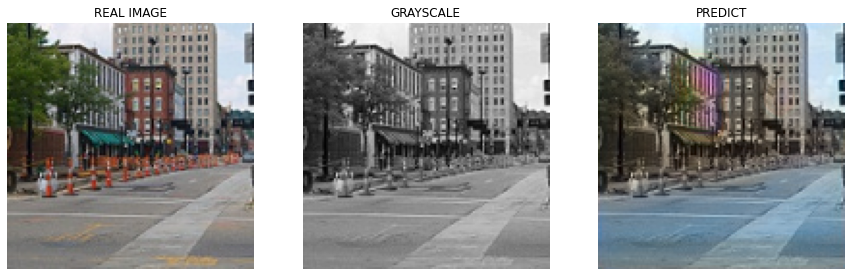

In [15]:
n_jpg = 2300
image_path = Path(IMAGES_DIR, f"{n_jpg}.jpg")

name_1 = "test"
name_2 = "test"

model_1 = load_my_model(name_1)


l_channel, ab_channel = preprocess_image(image_path)
new_ab_channel = predict_ab_channel(l_channel, model_1)
original_image = construct_image(l_channel, ab_channel)
new_image = construct_image(l_channel, new_ab_channel)

im_show = {
    "REAL IMAGE": original_image,
    "GRAYSCALE": l_channel,
    "PREDICT": new_image,
}
plot_images(im_show)